# <span style='color:blue'>   TP : La Segmentation bayésienne d’image</span>

## <span style='color:green'>   I) La segmentation bayésienne d’image </span>

###   Import des modules

In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import norm
from math import log2, sqrt

###   Définition des fonctions nécessaires

In [2]:
# Fonction de bruitage

def bruit_gauss2(X,cl1,cl2,m1,sig1,m2,sig2):
    return (X == cl1) * np.random.normal(m1, sig1, X.shape) + (X == cl2) * np.random.normal(m2, sig2, X.shape)

In [3]:
# Fonction de classification bayésienne MAP

def MAP_MPM2(Y,cl1,cl2,p1,p2,m1,sig1,m2,sig2):
    return np.where((p1*norm.pdf(Y, m1, sig1)) > (p2*norm.pdf(Y, m2, sig2)), cl1, cl2)

In [4]:
# Fonction du calcul de la probabilités de cl1, cl2 de X

def calc_probaprio2(X,cl1,cl2):
    return np.sum(X==cl1)/X.size, np.sum(X==cl2)/X.size

In [5]:
# Fonction du calcul du taux d'erreur

def taux_erreur(A,B):
    return np.count_nonzero(A!=B)/A.size

In [6]:
def get_line_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée selon un parcours ligne par ligne
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction ne fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours ligne par ligne
    """
    return [a.flatten() for a in np.indices((dSize, dSize))]

In [7]:
def line_transform_img(img):
    """
    Cette fonction prend une image carrée en entrée, et retourne l'image applatie (1 dimension) selon le parcours ligne par ligne
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0] == img.shape[1], 'veuillez donner une image carrée en entrée'
    idx = get_line_index(img.shape[0])
    return img[idx[0], idx[1]]

In [8]:
def transform_line_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours ligne par ligne
    :param img: un signal 1D
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize == int(np.sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_line_index(dSize)
    img = np.zeros((dSize, dSize))
    img[idx[0], idx[1]] = signal
    return img

In [9]:
def get_peano_index(dSize):
    """
    Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée (dont la dimension est une puissance de 2)
    selon la courbe de Hilbert-Peano
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours de Hilbert-Peano
    """
    assert log2(dSize).is_integer(), 'veuillez donne une dimension étant une puissance de 2'
    xTmp = 0
    yTmp = 0
    dirTmp = 0
    dirLookup = np.array(
        [[3, 0, 0, 1], [0, 1, 1, 2], [1, 2, 2, 3], [2, 3, 3, 0], [1, 0, 0, 3], [2, 1, 1, 0], [3, 2, 2, 1],
         [0, 3, 3, 2]]).T
    dirLookup = dirLookup + np.array(
        [[4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [4, 0, 0, 4], [0, 4, 4, 0], [0, 4, 4, 0], [0, 4, 4, 0],
         [0, 4, 4, 0]]).T
    orderLookup = np.array(
        [[0, 2, 3, 1], [1, 0, 2, 3], [3, 1, 0, 2], [2, 3, 1, 0], [1, 3, 2, 0], [3, 2, 0, 1], [2, 0, 1, 3],
         [0, 1, 3, 2]]).T
    offsetLookup = np.array([[1, 1, 0, 0], [1, 0, 1, 0]])
    for i in range(int(log2(dSize))):
        xTmp = np.array([(xTmp - 1) * 2 + offsetLookup[0, orderLookup[0, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[1, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[2, dirTmp]] + 1,
                         (xTmp - 1) * 2 + offsetLookup[0, orderLookup[3, dirTmp]] + 1])

        yTmp = np.array([(yTmp - 1) * 2 + offsetLookup[1, orderLookup[0, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[1, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[2, dirTmp]] + 1,
                         (yTmp - 1) * 2 + offsetLookup[1, orderLookup[3, dirTmp]] + 1])

        dirTmp = np.array([dirLookup[0, dirTmp], dirLookup[1, dirTmp], dirLookup[2, dirTmp], dirLookup[3, dirTmp]])

        xTmp = xTmp.T.flatten()
        yTmp = yTmp.T.flatten()
        dirTmp = dirTmp.flatten()

    x = - xTmp
    y = - yTmp
    return x, y

In [10]:
def peano_transform_img(img):
    """
    Cette fonction prend une image carrée (dont la dimension est une puissance de 2) en entrée,
    et retourne l'image applatie (1 dimension) selon le parcours de Hilbert-Peano
    :param img: une image (donc un numpy array 2 dimensions)
    :return: un numpy array 1 dimension
    """
    assert img.shape[0] == img.shape[1], 'veuillez donner une image carrée en entrée'
    assert log2(img.shape[0]).is_integer(), 'veuillez donne rune image dont la dimension est une puissance de 2'
    idx = get_peano_index(img.shape[0])
    return img[idx[0], idx[1]]

In [11]:
def transform_peano_in_img(signal, dSize):
    """
    Cette fonction prend un signal 1D en entrée et une taille, et le transforme en image carrée 2D selon le parcours de Hilbert-Peano
    :param img: un signal 1D
    :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
    :return: une image (donc un numpy array 2 dimensions)
    """
    assert dSize == int(sqrt(signal.shape[0])), 'veuillez donner un signal ayant pour dimension dSize^2'
    idx = get_peano_index(dSize)
    img = np.zeros((dSize, dSize))
    img[idx[0], idx[1]] = signal
    return img

## <span style='color:green'>   II) Modèle des couples indépendants </span>

###   3. Définition de la fonction <i> estim_param_EM_indep </i>

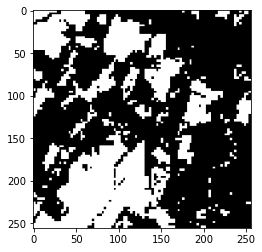

In [12]:
# Charger l'image
path = 'images/country2.bmp'
A = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)
plt.imshow(A, cmap='gray')

In [13]:
X = line_transform_img(A)

In [14]:
cl1_X, cl2_X = np.unique(X)
cl1_X, cl2_X

(0, 255)

In [15]:
m1= 0
sig1= 1
m2= 3
sig2= 2

In [16]:
Y = bruit_gauss2(X,cl1_X,cl2_X,m1,sig1,m2,sig2)

In [17]:
# Définition de la fonction qui initialise les paramètres
def init_param(Y):
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(Y.reshape(-1,1))
    Y_pred = kmeans.predict(Y.reshape(-1,1))
    cl1, cl2 = np.min(kmeans.labels_), np.max(kmeans.labels_)
    p10, p20 = calc_probaprio2(Y_pred,cl1,cl2)
    
    # Initialisation des m1, sig1, m2, sig2
    Ymap = pd.DataFrame([Y,Y_pred]).T
    Y0 = Ymap.loc[Ymap[1]==cl1]
    Y1 = Ymap.loc[Ymap[1]==cl2]
    m10 = Y0[0].mean()
    sig10 = Y0[0].std()
    m20 = Y1[0].mean()
    sig20 = Y1[0].std()

    return Y_pred, p10, p20, m10, sig10, m20, sig20

In [18]:
def estim_param_EM_indep (iter, Y, p1, p2, m1, sig1, m2, sig2):
    
    for i in range(iter):
    
        a = p1 * norm.pdf(Y,m1,sig1)
        b = p2 * norm.pdf(Y,m2,sig2)

        p1_new = a / (a+b)
        p2_new = b / (a+b)

        p1 = np.mean(p1_new)
        p2 = 1 - p1

        m1 = np.sum(Y*p1_new) / np.sum(p1_new)
        m2 = np.sum(Y*p2_new) / np.sum(p2_new)
        
        sig1 = np.sqrt(np.sum(((Y-m1)**2)*p1_new) / np.sum(p1_new))
        sig2 = np.sqrt(np.sum(((Y-m2)**2)*p2_new) / np.sum(p2_new))
    
    return p1, p2, m1, sig1, m2, sig2

In [19]:
Y_pred, p10, p20, m10, sig10, m20, sig20 = init_param(Y)

In [20]:
p1, p2, m1, sig1, m2, sig2 = estim_param_EM_indep (500, Y, p10, p20, m10, sig10, m20, sig20)

In [21]:
p1, p2, m1, sig1, m2, sig2

(0.35412607028996473,
 0.6458739297100353,
 2.997124417678777,
 2.0124369651362866,
 0.007814375978699814,
 1.0090651790857679)

In [22]:
S = MAP_MPM2(Y,cl1_X,cl2_X,p1, p2, m1, sig1, m2, sig2)
erreur = taux_erreur(X,S)
# Si l'erreur est >= 0.5, on intervertit les classes pour correspondre à l'image de base
if erreur >= 0.5:
    S_ = np.empty(S.shape)
    S_[S == cl1_X] = cl2_X
    S_[S == cl2_X] = cl1_X

else : S_ = S

erreur = taux_erreur(X,S_)

Erreur de semgentation: 11.94%


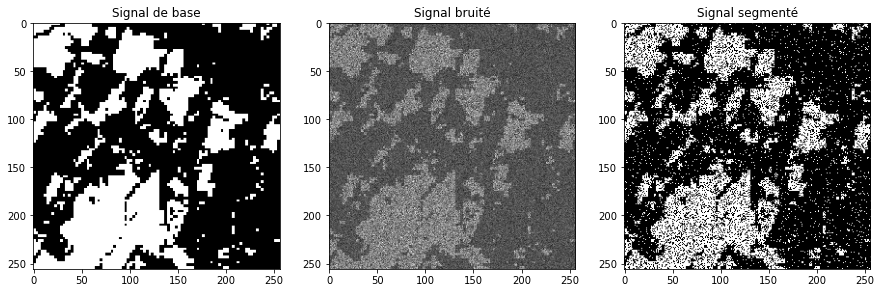

In [23]:
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(transform_line_in_img(X, 256), cmap='gray')
ax[0].set_title("Signal de base")
ax[1].imshow(transform_line_in_img(Y, 256), cmap='gray')
ax[1].set_title("Signal bruité")
ax[2].imshow(transform_line_in_img(S_, 256), cmap='gray')
ax[2].set_title("Signal segmenté")
print("Erreur de semgentation: {}%".format(np.round(erreur*100,2)))

In [24]:
def Segmentation_image_indep(path,m1,sig1,m2,sig2):
    
    A = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)
    
    X = line_transform_img(A)
    cl1_X, cl2_X = np.unique(X)
    
    # Bruitage du signal en fonction des classes et des valeurs du bruit en paramètre
    Y = bruit_gauss2(X,cl1_X,cl2_X,m1,sig1,m2,sig2)
    
    Y_pred, p10, p20, m10, sig10, m20, sig20 = init_param(Y)
    
    
    p1, p2, m1, sig1, m2, sig2 = estim_param_EM_indep (50, Y, p10, p20, m10, sig10, m20, sig20)
    
    S = MAP_MPM2(Y,cl1_X,cl2_X,p1,p2,m1,sig1,m2,sig2)
    erreur = taux_erreur(X,S)

    # Si l'erreur est >= 0.5, on intervertit les classes pour correspondre à l'image de base
    if erreur >= 0.5:
        S_ = np.empty(S.shape)
        S_[S == cl1_X] = cl2_X
        S_[S == cl2_X] = cl1_X
        
    else : S_ = S

    erreur = taux_erreur(X,S_)
    
    fig,ax = plt.subplots(1,3, figsize=(15,5))
    ax[0].imshow(transform_line_in_img(X, 256), cmap='gray')
    ax[0].set_title("Signal de base")
    ax[1].imshow(transform_line_in_img(Y, 256), cmap='gray')
    ax[1].set_title("Signal bruité")
    ax[2].imshow(transform_line_in_img(S, 256), cmap='gray')
    ax[2].set_title("Signal segmenté")

    
    print("L'erreur de ségmentation est de : {}%".format(np.round(100*erreur,2)))
    
    return 

In [25]:
# Creation des bruits

m1 = [0,1,0]
m2 = [3,1,1]
sig1 = [1, 1, 1]
sig2 = [2, 5, 1]

L'erreur de ségmentation est de : 11.05%


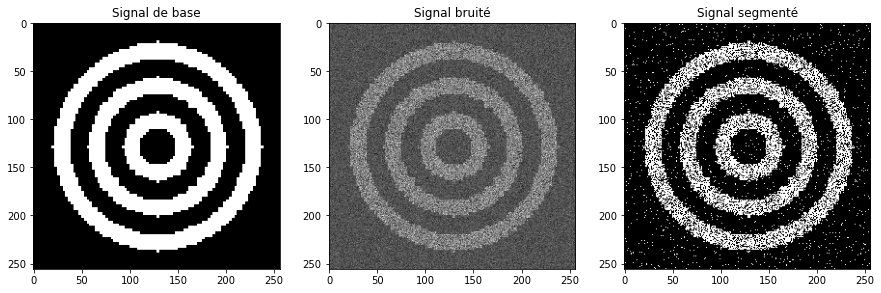

In [26]:
A = 'images/cible2.bmp'

Segmentation_image_indep(A, m1[0], sig1[0], m2[0], sig2[0])

###   5. Test sur 3 images avec les 3 bruits différents, affichage des résultats et commentaires

In [27]:
dict = {'Méthode':[], 'Image':[], 'Bruit':[], 'Erreur':[]}

In [28]:
def estimator(X,m1,sig1,m2,sig2):
    
    cl1_X, cl2_X = np.unique(X)
    
    # Bruitage du signal en fonction des classes et des valeurs du bruit en paramètre
    Y = bruit_gauss2(X,cl1_X,cl2_X,m1,sig1,m2,sig2)
    
    Y_pred, p10, p20, m10, sig10, m20, sig20 = init_param(Y)
    
    p1, p2, m1, sig1, m2, sig2 = estim_param_EM_indep (100, Y, p10, p20, m10, sig10, m20, sig20)
    S = MAP_MPM2(Y,cl1_X,cl2_X,p1,p2,m1,sig1,m2,sig2)
    erreur = taux_erreur(X,S)
    
    # Si l'erreur est >= 0.5, on intervertit les classes pour correspondre à l'image de base
    if erreur >= 0.5:
        S_ = np.empty(S.shape)
        S_[S == cl1_X] = cl2_X
        S_[S == cl2_X] = cl1_X
        
    else : S_ = S

    erreur = taux_erreur(X,S_)
    
    return S_, erreur

In [29]:
def show(path):
    
    A = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)
    X = line_transform_img(A)
    cl1_X, cl2_X = np.unique(X)
    
    Y=[]
    S_l=[]
    erreur_l=[]
    for i in range(len(m1)):
        Y.append(bruit_gauss2(X,cl1_X,cl2_X,m1[i], sig1[i], m2[i], sig2[i]))
        S, erreur = estimator(X, m1[i], sig1[i], m2[i], sig2[i])
        S_l.append(S)
        erreur_l.append(erreur)
        
        # Actualisation du tableau des résultats finaux
        dict['Méthode'].append('Bayes')
        dict['Image'].append(path)
        dict['Bruit'].append('Bruit '+str(i+1))
        dict['Erreur'].append(np.round(erreur*100,2))


    fig,ax = plt.subplots(3,3, figsize=(12,13))
    for i in range(len(m1)):
        ax[i,0].imshow(transform_line_in_img(X, 256), cmap='gray')
        ax[i,1].imshow(transform_line_in_img(Y[i], 256), cmap='gray')
        ax[i,2].imshow(transform_line_in_img(S_l[i], 256), cmap='gray')
        
        ax[i,0].set_xlabel("Signal de base")
        ax[i,1].set_xlabel("Signal bruité")
        ax[i,2].set_xlabel("Signal segmenté")
        
        ax[i,0].set_xticks([]), ax[i,0].set_yticks([]) 
        ax[i,1].set_xticks([]), ax[i,1].set_yticks([])
        ax[i,2].set_xticks([]), ax[i,2].set_yticks([])
        
        ax[i,0].set_title("Bruit {}:".format(i+1), color='blue')
        ax[i,1].set_title("$\mu$1 = {} / $\sigma$1 = {} // $\mu$2 = {} / $\sigma$2 = {}".format(i+1,m1[i],sig1[i],m2[i],sig2[i]), color='blue')
        ax[i,2].set_title("Erreur de ségmentation : {:.2f}%".format(erreur_l[i]*100), color='red')
        
        title = path.split('/')[1].split('.')[0]
        fig.suptitle("Image: {}".format(title))
        


In [30]:
# Rappel des bruits

m1 = [0,1,0]
m2 = [3,1,1]
sig1 = [1, 1, 1]
sig2 = [2, 5, 1]

CPU times: user 9.56 s, sys: 1.3 s, total: 10.9 s
Wall time: 6.75 s


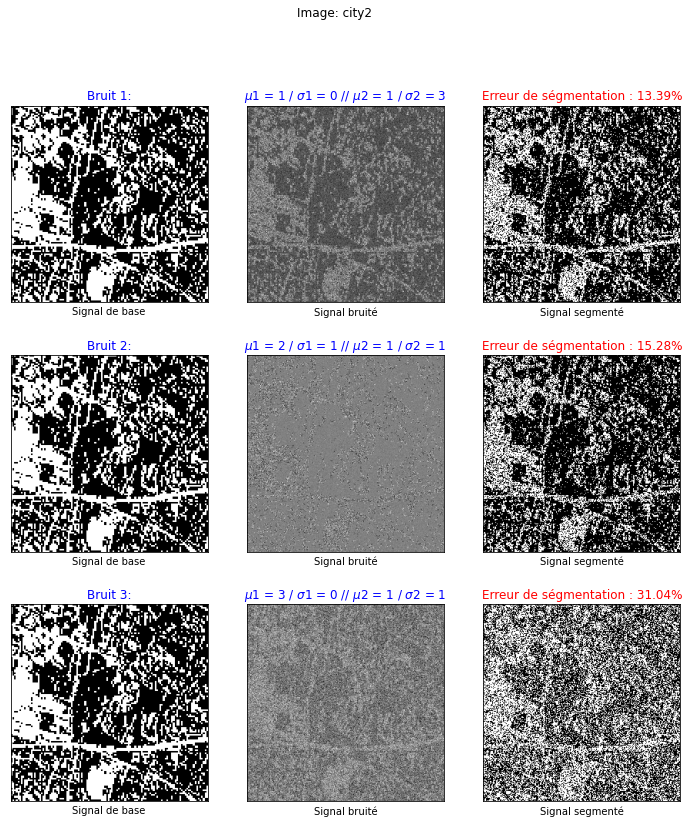

In [31]:
%%time
show('images/city2.bmp')

CPU times: user 10.2 s, sys: 1.45 s, total: 11.6 s
Wall time: 6.87 s


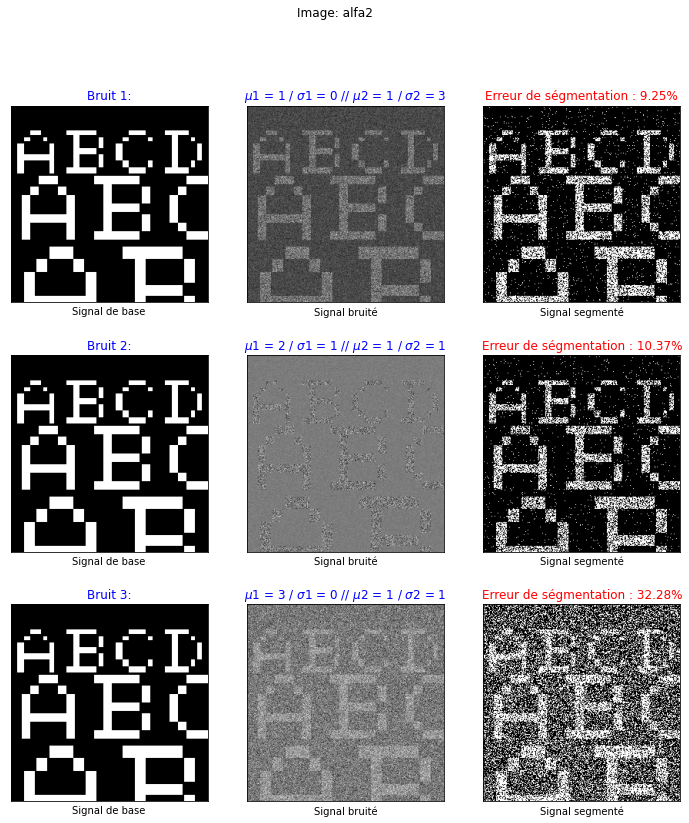

In [32]:
%%time
show('images/alfa2.bmp')

CPU times: user 9.33 s, sys: 1.13 s, total: 10.5 s
Wall time: 7.16 s


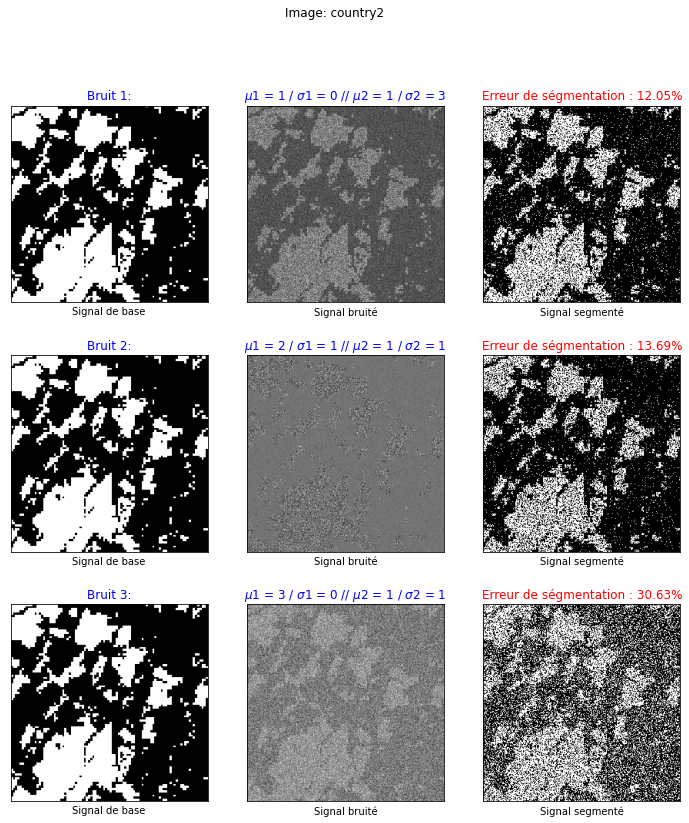

In [33]:
%%time
show('images/country2.bmp')

CPU times: user 9.58 s, sys: 1.26 s, total: 10.8 s
Wall time: 7.17 s


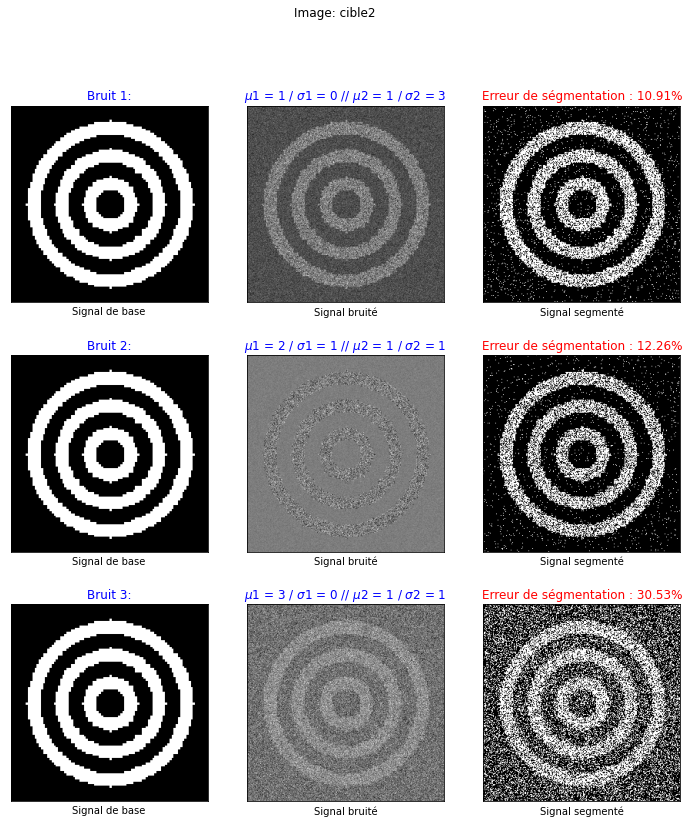

In [34]:
%%time
show('images/cible2.bmp')

In [35]:
rendu_prov = pd.DataFrame(dict)
rendu_prov['Image'] = rendu_prov['Image'].str.extract('images/(.*).bmp')
pd.pivot_table(rendu_prov, values='Erreur', index=['Méthode','Image'], columns=['Bruit'])

Bruit             Bruit 1  Bruit 2  Bruit 3
Méthode Image                              
Bayes   alfa2        9.25    10.37    32.28
        cible2      10.91    12.26    30.53
        city2       13.39    15.28    31.04
        country2    12.05    13.69    30.63

#### <span style='color:red'> <u> Commentaire & Interprétation des résultats </u></span>

- A partir des différentes images segmentées et du tableau récapitulatif ci-dessus, nous constatons d'une part les 'niveaux' de chaque bruit - Bruit 3 étant trois fois plus fort que Bruit 2 et Bruit 1, qui eux sont plus ou moins du même niveau.
- Nous remarquons aussi que l'hypothèse faite au départ sur les dépendances des variables aléatoires : les couples (𝑋𝑠,𝑌𝑠) sont indépendants nous permet d'aboutir à une reconstruction du signal 'caché' avec une précision entre 65% et 90% pour les différentes images en fonction du bruit considéré

## <span style='color:green'>   III) Modèle de chaîne de Markov cachées </span>

### 0. Chargement du signal test & bruitage

In [36]:
# Charger l'image & la bruiter
path = 'images/zebre2.bmp'
A = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)
X = peano_transform_img(A)
cl1_X, cl2_X = np.unique(X)
m1= 0
sig1= 1
m2= 3
sig2= 5
Y = bruit_gauss2(X,cl1_X,cl2_X,m1,sig1,m2,sig2)

### 1. Fonction mat_F

In [37]:
def gauss2(Y,m1,sig1,m2,sig2):
    mat_f = np.zeros((2,len(Y)))
    mat_f[0,:] = norm.pdf(Y,m1,sig1)
    mat_f[1,:] = norm.pdf(Y,m2,sig2)
    return mat_f

In [38]:
Y2 = gauss2(Y,m1,sig1,m2,sig2)

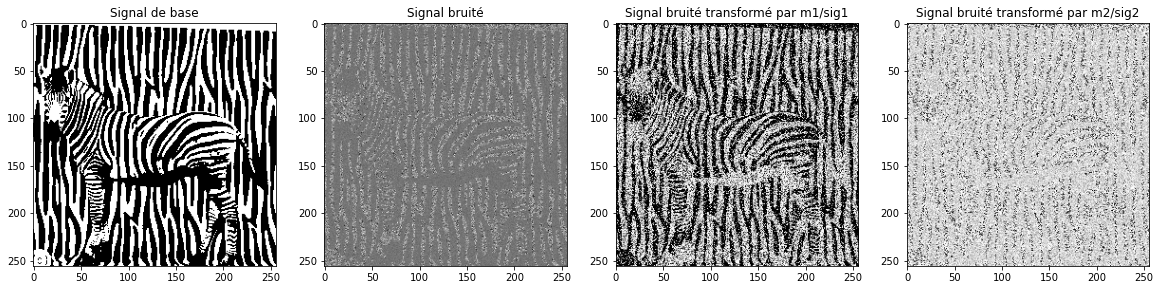

In [39]:
fig, ax = plt.subplots(1,4, figsize=(20,7))
ax[0].imshow(transform_peano_in_img(X,256), cmap='gray')
ax[0].set_title("Signal de base")
ax[1].imshow(transform_peano_in_img(Y,256), cmap='gray')
ax[1].set_title("Signal bruité")
ax[2].imshow(transform_peano_in_img(Y2[0],256), cmap='gray')
ax[2].set_title("Signal bruité transformé par m1/sig1")
ax[3].imshow(transform_peano_in_img(Y2[1],256), cmap='gray')
ax[3].set_title("Signal bruité transformé par m2/sig2");

### 2. Fonction Forward 2

In [40]:
# Initialisation aléatoire de p10, p20 et A pour tester les fonctions qu'on définit
p10, p20 = 0.4, 0.6
A = np.matrix('0.2 0.8;0.6 0.4')

In [41]:
# Définition de la fonction qui calcule la matrice Forward

def forward2(Mat_f,A,p10,p20):
    
    alpha = np.zeros(Mat_f.shape)
    
    a = p10 * Mat_f[0,0]
    b = p20 * Mat_f[1,0]

    alpha[0,0] = a / (a + b)
    alpha[1,0] = b / (a + b)
    
    for i in range(alpha.shape[1]-1):
        aa = (alpha[0,i]*A[0,0] + alpha[1,i]*A[1,0])  * Mat_f[0,i+1]
        bb = (alpha[0,i]*A[0,1] + alpha[1,i]*A[1,1])  * Mat_f[1,i+1]
        
        alpha[0, i+1] = aa / (aa + bb)
        alpha[1, i+1] = bb / (aa + bb)
    
    return alpha

In [42]:
alpha = forward2(Y2, A, p10, p20)

### 3. Fonction Backward 2

In [43]:
# Définition de la fonction qui calcule la matrice Backward

def backward2(Mat_f,A):
    
    n = Mat_f.shape[1]
    
    beta = np.zeros(Mat_f.shape)
    
    a = 1
    b = 1
    
    beta[0,-1] = a / (a + b)
    beta[1,-1] = b / (a + b)
    
    for i in range(n-1,0,-1):
        aa = (beta[0, i] * A[0,0] * Mat_f[0,i]) + (beta[1, i] * A[0,1] * Mat_f[1,i])
        bb = (beta[0, i] * A[1,0] * Mat_f[0,i]) + (beta[1, i] * A[1,1] * Mat_f[1,i])
    
        beta[0, i-1] = aa / (aa + bb)
        beta[1, i-1] = bb / (aa + bb)
    
        
    return beta

In [44]:
beta = backward2(Y2,A)

### 4. Fonction MPM_chaines2

$$ p(X = \omega_i / y ; \theta)= \frac{{\alpha(\omega_i)}.{\beta(\omega_i)}}{\sum_{\omega_i}{\alpha(\omega_i)}.{\beta(\omega_i)}} = \gamma(X = \omega_i)$$

In [45]:
# On définit une fonction qui calcule la matrice gamma pour chaque classe

def Ksi (alpha, beta):
    
    G = alpha * beta
    
    ksi = G / np.sum(G, axis=0)
    
    return ksi

In [46]:
ksi = Ksi(alpha, beta)

In [47]:
def MPM_chaines2(Mat_f,cl1,cl2,A,p10,p20):
    
    n = Mat_f.shape[1]
    
    # On construit les matrices alpha et beta
    alpha = forward2(Mat_f,A,p10,p20)
    beta = backward2(Mat_f,A)
    ksi = Ksi(alpha, beta)

    X_apost = np.where(ksi[0,:] >= ksi[1,:] ,cl1 ,cl2 )
    
    return X_apost

In [48]:
X_apost = MPM_chaines2(Y2, cl1_X,cl2_X,A,p10,p20)
erreur = taux_erreur(X, X_apost)

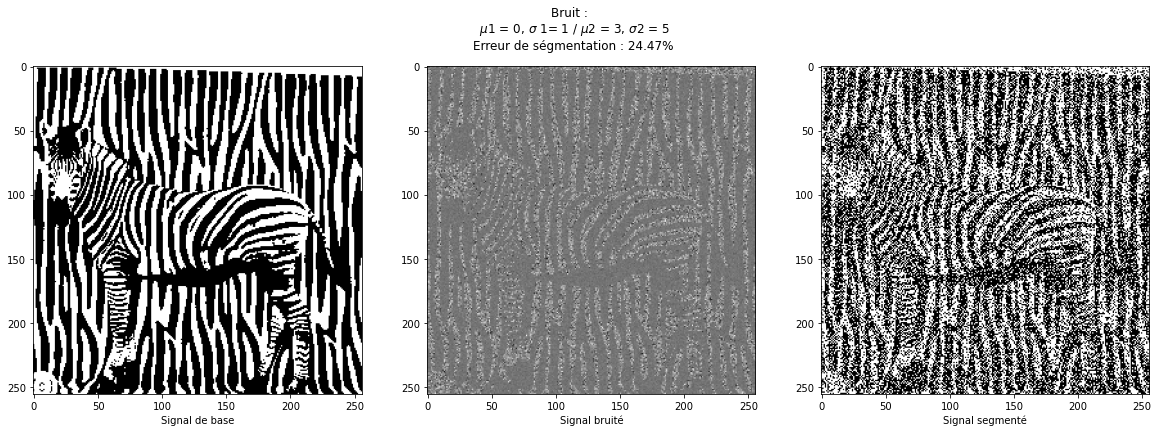

In [49]:
fig, ax = plt.subplots(1,3, figsize=(20,6.5))
ax[0].imshow(transform_peano_in_img(X,256), cmap='gray');
ax[1].imshow(transform_peano_in_img(Y,256), cmap='gray');
ax[2].imshow(transform_peano_in_img(X_apost,256), cmap='gray')

ax[0].set_xlabel("Signal de base")
ax[1].set_xlabel("Signal bruité")
ax[2].set_xlabel("Signal segmenté")

fig.suptitle("Bruit :  \n $\mu$1 = {}, $\sigma$ 1= {} / $\mu$2 = {}, $\sigma$2 = {}\nErreur de ségmentation : {:.2f}%".format(m1,sig1,m2,sig2,erreur*100));


### 5. Fonction Calc proba à prio

In [50]:
def calc_probaprio_mc(X, cl1,cl2):
    
    p = [(X == cl1).mean(), (X == cl2).mean()]
    
    A = np.array(pd.crosstab(X[:-1], X[1:], normalize=1).T)
    
    return p , A

In [51]:
cl1,cl2 = np.unique(X)
p, A = calc_probaprio_mc(X, cl1,cl2)

### 6. Fonction estim_param_EC_mc

In [52]:
# Définition de la fonction qui calcule la matrice Psi

def Psi(Y2, A, alpha, beta):
    
    af = A.flatten()
    a2 = np.vstack((alpha[0],alpha[0],alpha[1],alpha[1])).T
    b2 = np.hstack((beta.T, beta.T))
    y2 = np.hstack((Y2.T, Y2.T))
    ps2 = a2[:-1, :] * af * y2[1:,:] * b2[1:, :]
    psi = (ps2 / np.sum(ps2, axis=1).reshape(-1,1)).T
        
    return psi

In [53]:
def estim_param_EM_mc(iter, Y, A, p10, p20, m1, sig1, m2, sig2):

    for i in range(iter):
        
        Y2 = gauss2(Y, m1, sig1, m2, sig2)
        
        # Calcul des matrices d'aide à l'estimation des paramètres
        alpha = forward2(Y2, A, p10, p20)
        beta = backward2(Y2,A)
        ksi = Ksi(alpha, beta)
        psi = Psi(Y2, A, alpha, beta)
        
        p10 = ksi[0].mean()
        p20 = ksi[1].mean()

        ksif = np.vstack((ksi[0],ksi[0],ksi[1],ksi[1]))
        A = (psi.sum(axis=1) / np.sum(ksif[:,:-2], axis=1)).reshape(2,2)
        
        m1 = (Y2[0] * ksi[0]).sum() / ksi[0].sum()
        m2 = (Y2[1] * ksi[1]).sum() / ksi[1].sum()

        sig1 = np.sqrt((((Y-m1)**2) * ksi[0]).sum() / ksi[0].sum() )
        sig2 = np.sqrt((((Y-m2)**2) * ksi[1]).sum() / ksi[1].sum() )
    
    return A, p10, p20, m1, sig1, m2, sig2

### 7. Fonction Segmentation

In [54]:
# Définition de la fonction qui initialise les paramètres
def init_param(Y):
    
    kmeans = KMeans(n_clusters=2, random_state=0).fit(Y.reshape(-1,1))
    cl1, cl2 = np.min(kmeans.labels_), np.max(kmeans.labels_)
    Y_pred = kmeans.predict(Y.reshape(-1,1))
    
    # Initialisation des m1, sig1, m2, sig2
    Ymap = pd.DataFrame([Y,Y_pred]).T
    Y0 = Ymap.loc[Ymap[1]==cl1]
    Y1 = Ymap.loc[Ymap[1]==cl2]
    m10 = Y0[0].mean()
    sig10 = Y0[0].std()
    m20 = Y1[0].mean()
    sig20 = Y1[0].std()
    
    return Y_pred, cl1, cl2, m10, sig10, m20, sig20

In [55]:
# Définition de la fonction Segmentaion qui fait tout
def result(path,m1,sig1,m2,sig2):
    
    # Acquisition de l'image
    B = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)
    
    # Transformation Peano de l'image
    X = peano_transform_img(B)

    # Classes
    cl1_X, cl2_X = np.unique(X)

    # Bruitage de l'image
    Y = bruit_gauss2(X,cl1_X,cl2_X,m1,sig1,m2,sig2)
    
    # Transformation du processus bruité par les densités du bruit 
    Y2 = gauss2(Y, m1, sig1, m2, sig2)
    
    # Initialisation des paramètres
    Y_pred, cl1, cl2, m10, sig10, m20, sig20  = init_param(Y)
    
    p, A = calc_probaprio_mc(Y_pred, cl1,cl2)
    p10 = p[0] 
    p20 = p[1]

    # Estimation des paramètres
    A, p10, p20, m1, sig1, m2, sig2 = estim_param_EM_mc(10, Y, A, p10, p20, m10, sig10, m20, sig20)

    # Segmentation de l'image à deux classes selon le MMC
    S = MPM_chaines2(Y2, cl1_X,cl2_X,A,p10,p20)

    # Calcul du taux d'erreur
    erreur = taux_erreur(X,S)
    
    # Si l'erreur est >= 0.5, on intervertit les classes pour correspondre à l'image de base
    if erreur >= 0.5:
        S_ = np.empty(S.shape)
        S_[S == cl1_X] = cl2_X
        S_[S == cl2_X] = cl1_X
        
    else : S_ = S

    erreur = taux_erreur(X,S_)
    

    return S_, erreur

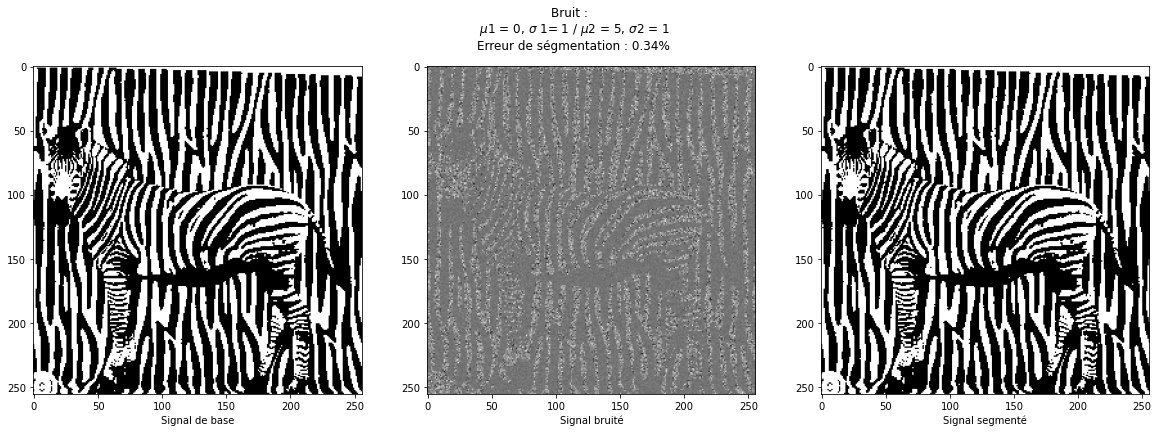

In [56]:
m1= 0
sig1= 1
m2= 5
sig2= 1

# Charger l'image
path = 'images/zebre2.bmp'
S2, erreur = result(path,m1,sig1,m2,sig2)

fig, ax = plt.subplots(1,3, figsize=(20,6.5))
ax[0].imshow(transform_peano_in_img(X,256), cmap='gray')
ax[1].imshow(transform_peano_in_img(Y,256), cmap='gray')
ax[2].imshow(transform_peano_in_img(S2,256), cmap='gray')

ax[0].set_xlabel("Signal de base")
ax[1].set_xlabel("Signal bruité")
ax[2].set_xlabel("Signal segmenté")

fig.suptitle("Bruit :  \n $\mu$1 = {}, $\sigma$ 1= {} / $\mu$2 = {}, $\sigma$2 = {}\nErreur de ségmentation : {:.2f}%".format(m1,sig1,m2,sig2,erreur*100));


### 8. Test de la méthode sur les 3 bruits & comparaison des résultats

In [57]:
# Rappel des bruits

m1 = [0,1,0]
m2 = [3,1,1]
sig1 = [1, 1, 1]
sig2 = [2, 5, 1]

In [58]:
def show_mc(path):
    
    A = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2GRAY)
    X = peano_transform_img(A)
    # Bruitage de l'image
    cl1_X, cl2_X = np.unique(X)
    
    Y=[]
    S_l=[]
    erreur_l=[]
    for i in range(len(m1)):
        Y.append(bruit_gauss2(X,cl1_X,cl2_X,m1[i], sig1[i], m2[i], sig2[i]))
        S, erreur = result(path, m1[i], sig1[i], m2[i], sig2[i])
        S_l.append(S)
        erreur_l.append(erreur)
        
        # Actualisation du tableau des résultats finaux
        dict['Méthode'].append('Markov')
        dict['Image'].append(path)
        dict['Bruit'].append('Bruit '+ str(i+1))
        dict['Erreur'].append(np.round(erreur*100,2))

    fig,ax = plt.subplots(3,3, figsize=(12,13))
    
    for i in range(len(m1)):
        ax[i,0].imshow(transform_peano_in_img(X, 256), cmap='gray')
        ax[i,1].imshow(transform_peano_in_img(Y[i], 256), cmap='gray')
        ax[i,2].imshow(transform_peano_in_img(S_l[i], 256), cmap='gray')
        
        ax[i,0].set_xlabel("Signal de base")
        ax[i,1].set_xlabel("Signal bruité")
        ax[i,2].set_xlabel("Signal segmenté")
        
        ax[i,0].set_xticks([]), ax[i,0].set_yticks([]) 
        ax[i,1].set_xticks([]), ax[i,1].set_yticks([])
        ax[i,2].set_xticks([]), ax[i,2].set_yticks([])
        
        ax[i,0].set_title("Bruit {}:".format(i+1), color='blue')
        ax[i,1].set_title("$\mu$1 = {} / $\sigma$1 = {} // $\mu$2 = {} / $\sigma$2 = {}".format(i+1,m1[i],sig1[i],m2[i],sig2[i]), color='blue')
        ax[i,2].set_title("Erreur de ségmentation : {:.2f}%".format(erreur_l[i]*100), color='red')
        
        title = path.split('/')[1].split('.')[0]
        fig.suptitle("Image: {}".format(title))

CPU times: user 17.1 s, sys: 1.34 s, total: 18.5 s
Wall time: 14.4 s


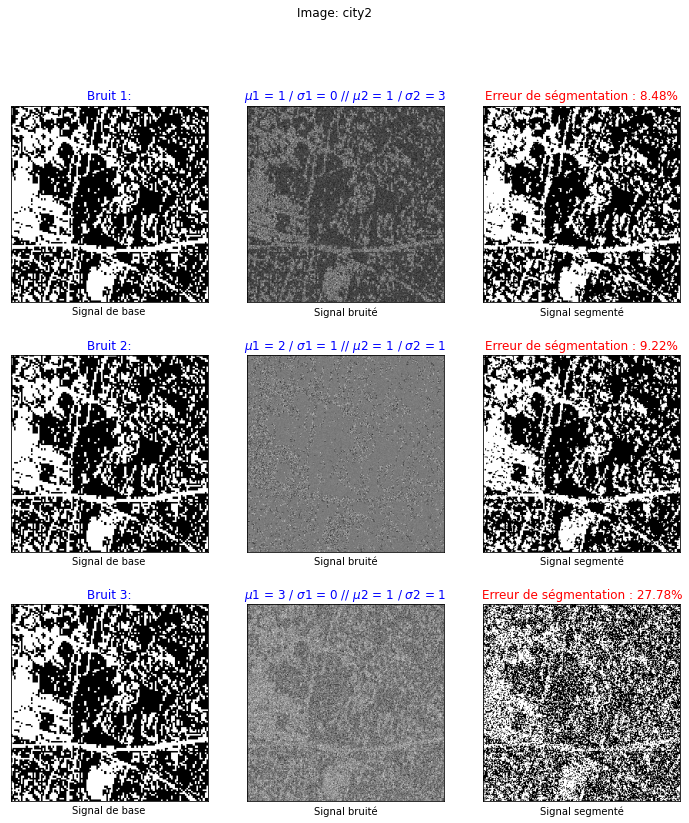

In [59]:
%%time
show_mc('images/city2.bmp')

CPU times: user 17.4 s, sys: 1.52 s, total: 18.9 s
Wall time: 16.6 s


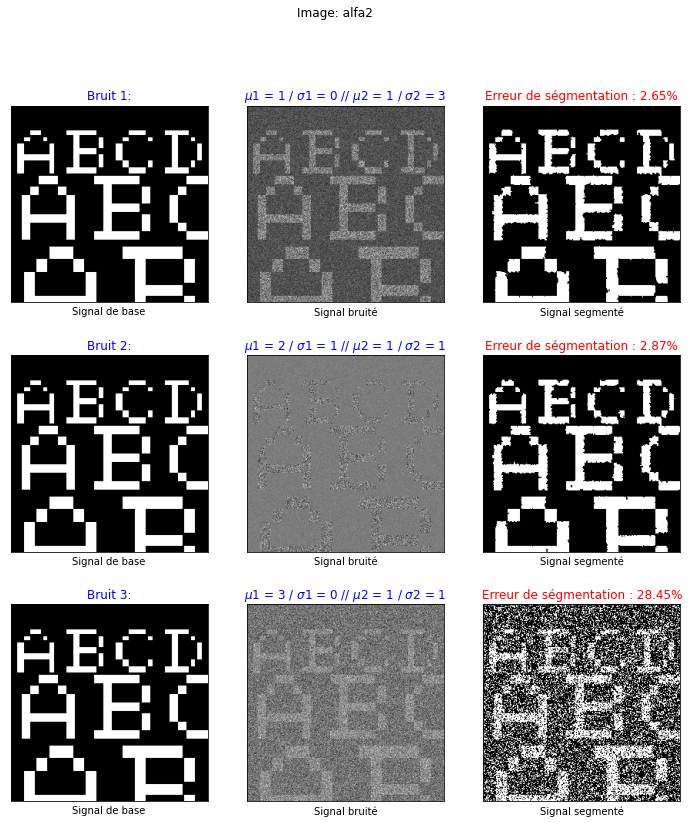

In [60]:
%%time
show_mc('images/alfa2.bmp')

CPU times: user 17.9 s, sys: 1.53 s, total: 19.5 s
Wall time: 14.6 s


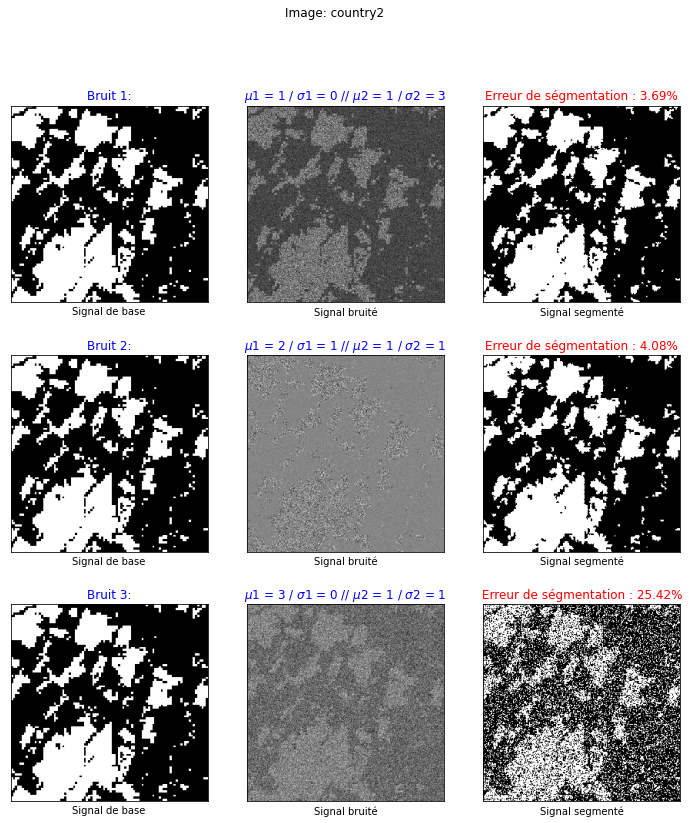

In [61]:
%%time
show_mc('images/country2.bmp')

CPU times: user 17.6 s, sys: 1.49 s, total: 19.1 s
Wall time: 14.5 s


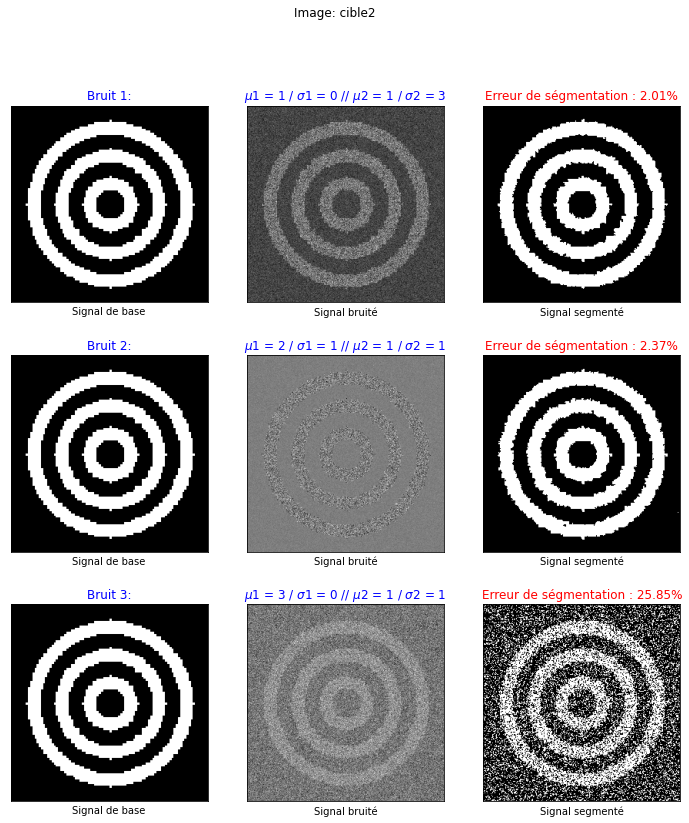

In [62]:
%%time
show_mc('images/cible2.bmp')

In [63]:
rendu = pd.DataFrame(dict)
rendu['Image'] = rendu['Image'].str.extract('images/(.*).bmp')
pd.pivot_table(rendu, values='Erreur', index=['Méthode','Image'], columns=['Bruit'])

Bruit             Bruit 1  Bruit 2  Bruit 3
Méthode Image                              
Bayes   alfa2        9.25    10.37    32.28
        cible2      10.91    12.26    30.53
        city2       13.39    15.28    31.04
        country2    12.05    13.69    30.63
Markov  alfa2        2.65     2.87    28.45
        cible2       2.01     2.37    25.85
        city2        8.48     9.22    27.78
        country2     3.69     4.08    25.42

#### <span style='color:red'> <u> Commentaire & Interprétation des résultats </u></span>

- Encore une fois, à partir des différentes images segmentées et du tableau récapitulatif ci-dessus, nous confirmons l'hypothèse faite sur les 'niveaux' de chaque bruit. Nous notons tout de même que le MMC a bien mieux réussi à classer les images quand elles sont soumises au Bruit 1 et Bruit 2 que quand elles sont soumises au Bruit 3.

- Nous notons que l'image 'city2' est la moins bien restituée, pour les deux méthodes. Cela peut être dû à l'image elle-même et de la répartition des pixels.

- D'autre part, nous constatons une amélioration significative de l'efficacité de notre classificateur, de l'ordre de 5% à 10% selon les cas de figures.

- Enfin, nous pouvons conclure que l’hypothèse où (𝑿,𝒀) forme une chaîne de Markov cachée stationnaire est mieux fondée que celle reposant sur leur indépendance, au vu des résultats empiriques, et aboutit à des résultats beaucoup plus intéressants.